In [11]:
#imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cartopy.geodesic
import cartopy.crs as ccrs
import seaborn as sn
import pandas as pd
import geopy.distance
import shapely.geometry
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor


In [12]:
#read data and remove rows with missing values
df = pd.read_csv('flats.csv')
df = df.drop(columns=['name'])
print(df.isna().sum())
df = df.dropna()


Unnamed: 0     0
lat            0
long           0
price          0
rooms         22
size           7
dtype: int64


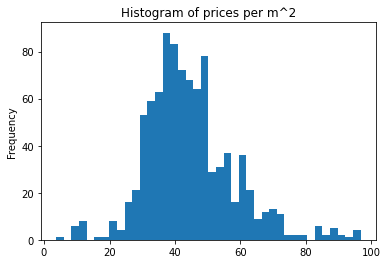

In [13]:
#we will predict price per square meter
df['price/size'] = df.apply(lambda x: x['price'] / x['size'], axis=1)
df_price = df.drop(columns=['price', 'Unnamed: 0'])

df_price = df_price[df_price['price/size'] < 100]
df_price['price/size'].plot.hist(bins=40)
plt.title('Histogram of prices per m^2')
plt.show()

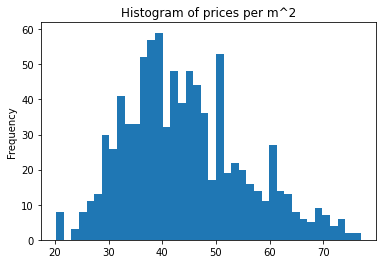

In [14]:
#remove outliers
df_cut = df_price[df_price['price/size'] > 20]
df_cut = df_cut[df_cut['price/size'] < 80]
df_cut['price/size'].plot.hist(bins=40)
plt.title('Histogram of prices per m^2')
plt.show()

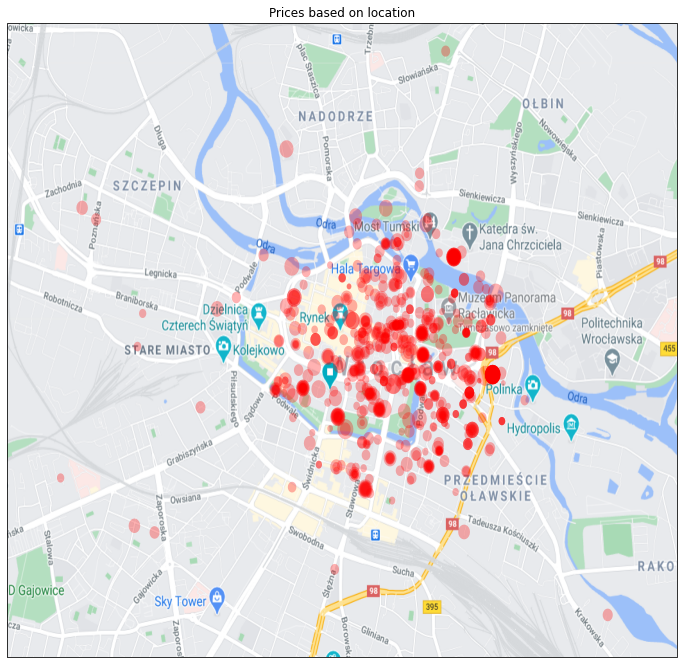

In [15]:
#show data on a map
plt.figure(figsize=(12, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.title('Prices based on location')
img_extent = (16.997416, 17.105600, 51.092244, 51.126107)
img = plt.imread('wroclaw.png')
ax.imshow(img, origin='upper', extent=img_extent, transform=ccrs.PlateCarree())

for index, row in df_cut.iterrows():
    circle_points = cartopy.geodesic.Geodesic().circle(lon=row['long'],
                                                       lat=row['lat'],
                                                       radius=row['price/size']*0.8,
                                                       n_samples=20,
                                                       endpoint=False)
    geom = shapely.geometry.Polygon(circle_points)
    ax.add_geometries((geom,), crs=cartopy.crs.PlateCarree(), facecolor='red', edgecolor='none', linewidth=0, alpha=0.3)

ax.set_aspect(1587.0/797)
ax.set_extent((16.997416, 17.068600, 51.092244, 51.126107), crs=ccrs.PlateCarree())
plt.show()

In [16]:
#calculate distances from important locations  

#dictionary of geo-coordinates of important locations 
places = {
    'city_center': (51.1100686, 17.0319407),
    'railway_station': (51.099627, 17.032973),
    'pwr': (51.1073415, 17.0596074),
    'uwr': (51.1140053, 17.0322743),
    'ue': (51.0904575, 17.0222728),
    'awf': (51.1176873, 17.0864211),
}

for place_name, place_location in places.items():
    df_cut['distance_' + place_name] = df_cut.apply(lambda x:geopy.distance.distance(
        (x['lat'], x['long']), place_location).km,
                               axis=1)
    
df_cut.head()    

,lat,long,rooms,size,price/size,distance_city_center,distance_railway_station,distance_pwr,distance_uwr,distance_ue,distance_awf
0,51.102405,17.042242,2.0,44.0,43.181818,1.116877,0.719053,1.334502,1.467243,1.929649,3.530289
1,51.102405,17.042242,5.0,160.0,50.000000,1.116877,0.719053,1.334502,1.467243,1.929649,3.530289
2,51.105349,17.039620,1.0,23.0,58.695652,0.751622,0.788661,1.417301,1.091808,2.054563,3.553280
3,51.112438,17.035608,3.0,60.0,36.666667,0.368021,1.437126,1.773779,0.291377,2.617657,3.605738
4,51.108366,17.041609,2.0,50.0,36.000000,0.703093,1.145021,1.265657,0.906053,2.409128,3.304961


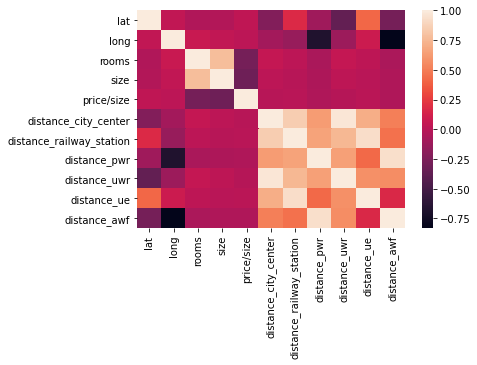

In [17]:
#show correlation matrix
corrMatrix = df_cut.corr()
sn.heatmap(corrMatrix, annot=False)
plt.show()

Modeling

In [18]:
#modeling
X = df_cut.drop(columns=['price/size']).values
y = df_cut['price/size'].values.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

scaler_x = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_x.fit_transform(X_train)
y_train = scaler_y.fit_transform(y_train).ravel()
X_test = scaler_x.transform(X_test)
y_test = scaler_y.transform(y_test).ravel()

svm = SVR()
lr = LinearRegression()
dtr = DecisionTreeRegressor(max_depth=5)
nn = MLPRegressor(hidden_layer_sizes=(400, ),
                  learning_rate='adaptive',
                  alpha=0.5,
                  max_iter=1000)

models = {
    'svm': svm,
    'linear_regression': lr,
    'decision_tree_regressor': dtr,
    'neural_network': nn
}

for name, model in models.items():
    model.fit(X_train, y_train)

print('TRAIN SET')
for name, model in models.items():
    score = model.score(X_train, y_train)
    print('{} - {}'.format(name, score))

print('\nTEST SET')
for name, model in models.items():
    score = model.score(X_test, y_test)
    print('{} - {}'.format(name, score))

TRAIN SET
svm - 0.4021189100656166
linear_regression - 0.13453913572294995
decision_tree_regressor - 0.5002302698619123
neural_network - 0.48886756593123004

TEST SET
svm - 0.2954093745940758
linear_regression - 0.050716475280871975
decision_tree_regressor - 0.3036728129258487
neural_network - 0.29807190609105183


In [19]:
#show prices on map

#resolution
width = 200
height = 100


lon = np.linspace(16.997416,17.105600, width)
lat = np.linspace(51.092244,51.126107, height)
lon, lat = np.meshgrid(lon, lat)

lon_flattened = lon.reshape(-1)
lat_flattened = lat.reshape(-1)
grid_df = pd.DataFrame(data={'lat':lat_flattened,'long':lon_flattened})
grid_df['rooms'] = 1
grid_df['size'] = 25

for place_name, place_location in places.items():
    grid_df['distance'+place_name] = grid_df.apply(lambda x: geopy.distance.distance(
        (x['lat'], x['long']),
        place_location).km, axis=1)

print(grid_df.head())
grid_matrix = grid_df.values

#scale values
grid_matrix = scaler_x.fit_transform(grid_matrix)
#predict with best model
grid_values = svm.predict(grid_matrix)
grid_values = grid_values.reshape(height, width)
#inverse scale predictions
grid_values = scaler_y.inverse_transform(grid_values)

         lat       long  rooms  size  distancecity_center  \
0  51.092244  16.997416      1    25             3.127352   
1  51.092244  16.997960      1    25             3.098001   
2  51.092244  16.998503      1    25             3.068841   
3  51.092244  16.999047      1    25             3.039879   
4  51.092244  16.999591      1    25             3.011120   

   distancerailway_station  distancepwr  distanceuwr  distanceue  distanceawf  
0                 2.622795     4.668895     3.438333    1.752766     6.846382  
1                 2.586655     4.633384     3.411400    1.714930     6.811731  
2                 2.550571     4.597915     3.384680    1.677105     6.777117  
3                 2.514546     4.562488     3.358180    1.639292     6.742539  
4                 2.478583     4.527103     3.331905    1.601493     6.708000  


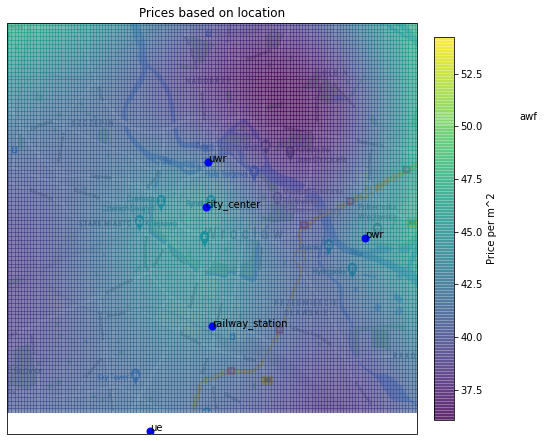

In [20]:
plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.title('Prices based on location')


img_extent = (16.997416, 17.105600, 51.092244, 51.126107)
img = plt.imread('wroclaw.png')
plt.pcolormesh(lon, lat, grid_values, transform=ccrs.PlateCarree(), alpha=0.6,
               cmap='viridis')
ax.imshow(img, origin='upper', extent=img_extent, transform=ccrs.PlateCarree())


for name, location in places.items():
    ax.plot(location[1], location[0], 'bo', markersize=7, transform=ccrs.PlateCarree())
    ax.text(location[1], location[0], name, transform=ccrs.PlateCarree())

ax.set_extent((16.997416, 17.068600, 51.090244, 51.126107), crs=ccrs.PlateCarree())
ax.set_aspect(1587.0/797)
plt.colorbar(label='Price per m^2', fraction=0.043, pad=0.04)
plt.show()